# MODELO 4: 

* Filtros: Color_BP_RP!=-9999, G_Magnitude!=-9999, Temperature_Eff!=-9999, SNR > 20
* Random: SI
* Funciones de act.: >PARALAJE: relu -> tanh -> relu -> tanh -> relu -> softplus
                 >OFFSET: relu -> relu -> tanh
* Loss: mse
* Épocas: 200
* Batch size: 256
* Discriminación por SNR: SI
* Tamaños train/cv/test: 6000(4000 buen SNR + 2000 mal SNR),2000(mal SNR),2000(mal SNR)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from keras.layers import Conv1D , Dropout , Flatten , MaxPooling1D, Dense, Input
from keras.layers.core import Lambda
from keras.models import Model
import pandas as pd
import random
from sklearn.metrics import r2_score

Optimization process  

# Parallax prediction with Optimization
(Next to the notebook "thesisNNtrain.ipynb")

In [2]:
Data = pd.read_csv("/home/anell/Desktop/Bovy/AnellExercises/data_matched/MatchApogeeGaia(0-28500).csv")

Parallax = np.array(Data["parallax"])
Parallax_error = np.array(Data["parallax_error"])
Corrected_magnitude = np.array(Data["corrected_magnitude"])
Spectra = fits.open('/home/anell/Desktop/Bovy/AnellExercises/data_matched/contspec_dr14(0-28500).fits')[0].data

#To optimize 
SNR = np.array(Data["SNR"])
G_Magnitude = np.array(Data["phot_g_mean_mag"])
Color_BP_RP = np.array(Data["bp_rp"])
Temperature_Eff = np.array(Data["NN-teff"])
Logg = np.array(Data["NN-logg"])

In [3]:
good_idx , bad_idx=  [] , []
for i in range(len(Temperature_Eff)):
    if (Color_BP_RP[i] != -9999.) and (G_Magnitude[i] != -9999.) and (Temperature_Eff[i] != -9999.) and (SNR[i] > 20):# and (Parallax_error[i] / Parallax[i] < 0.1):
        good_idx.append(i)
    else:
        bad_idx.append(i)
        
parallax = Parallax[good_idx]
parallax_error = Parallax_error[good_idx]
corrected_magnitude = Corrected_magnitude[good_idx]
spectra = Spectra[good_idx]

Snr = SNR[good_idx]
G_magnitude = G_Magnitude[good_idx]
Color_bp_rp = Color_BP_RP[good_idx]
Temperature_eff = Temperature_Eff[good_idx]
logg = Logg[good_idx]



#Normalization to G, Color and Teff
G_magnitude_std = np.std(G_magnitude)
G_magnitude_mean = np.mean(G_magnitude)
norm_G_magnitude = (G_magnitude - G_magnitude_mean) / G_magnitude_std

Color_std = np.std(Color_bp_rp)
Color_mean = np.mean(Color_bp_rp)
norm_Color_bp_rp = (Color_bp_rp - Color_mean) / Color_std

Teff_std = np.std(Temperature_eff)
Teff_mean = np.mean(Temperature_eff)
norm_Temperature_eff = (Temperature_eff - Teff_mean) / Teff_std

In [4]:
def size_dataset(X,Y,K,offset,m,train=None, cv = None, test =None):
    """
    INPUT:
    X.shape = (m,7514,1)
    Y.shape = (m,1)
    K.shape = (m,1)
    offset.shape = (m,3)
    """
   
    if (train == True) and (cv == True) and (test == True):
        
        X_train = X[:int(0.6*m),:,:]
        Y_train = Y[:int(0.6*m)]
        K_train = K[:int(0.6*m)]
        offset_train = offset[:int(0.6*m)]
    
        X_cv = X[int(0.6*m):int(0.8*m),:,:]
        Y_cv = Y[int(0.6*m):int(0.8*m)]
        K_cv = K[int(0.6*m):int(0.8*m)]
        offset_cv = offset[int(0.6*m):int(0.8*m)]

        X_test = X[int(0.8*m):m,:,:]
        Y_test = Y[int(0.8*m):m]
        K_test = K[int(0.8*m):m]
        offset_test = offset[int(0.8*m):m]
        
        #print("Train,CV,Test")
        return [X_train, Y_train, K_train, offset_train], [X_cv, Y_cv, K_cv, offset_cv],[X_test, Y_test, K_test, offset_test]
    
    elif (train == False) and (cv == True) and (test == True): 
    
        X_cv = X[:int(0.2*m),:,:]
        Y_cv = Y[:int(0.2*m)]
        K_cv = K[:int(0.2*m)]
        offset_cv = offset[:int(0.2*m)]

        X_test = X[int(0.2*m):int(0.4*m),:,:]
        Y_test = Y[int(0.2*m):int(0.4*m)]
        K_test = K[int(0.2*m):int(0.4*m)]
        offset_test = offset[int(0.2*m):int(0.4*m)]
        
        #print("CV,Test")
        return [X_cv, Y_cv, K_cv, offset_cv],[X_test, Y_test, K_test, offset_test]
    
    elif (train == True) and (cv == False) and (test == False): 
        
        X_train = X[:int(0.6*m),:,:]
        Y_train = Y[:int(0.6*m)]
        K_train = K[:int(0.6*m)]
        offset_train = offset[:int(0.6*m)]
        
        #print("Train")
        return [X_train, Y_train, K_train, offset_train]
    
###################################################################################################################
###################################################################################################################

def ApogeeDR14GaiaDR2(dim_t , dim_n): 
    """
    INPUT: 
    dim_t - number of time steps of spectrum 
    dim_n - number of features of spectrum
    """
    
    #SPECTRUM TO LUINOSITY
    dim_1 = 1 # number of corrected magnitude for one example 
    units = 1 #number of final output for one example
    inputs_spectra = Input(shape=(dim_t, dim_n)) 
    inputs_mag = Input(shape=(dim_1,), name="ApparentMagnitude-input")
    
    x_parallax = Conv1D(filters=4, kernel_size=2, activation='relu')(inputs_spectra)
    x_parallax = MaxPooling1D(pool_size=2)(x_parallax)
    #x_parallax = Conv1D(filters=4, kernel_size=2, activation='relu')(x_parallax)
    #x_parallax = MaxPooling1D(pool_size=2)(x_parallax)
    x_parallax = Flatten()(x_parallax)
    x_parallax = Dense(164, activation='relu')(x_parallax) 
    x_parallax = Dense(164, activation='tanh')(x_parallax) #tanh
    x_parallax = Dense(64, activation='relu')(x_parallax) 
    x_parallax = Dense(64, activation='tanh')(x_parallax)
    x_parallax = Dense(32, activation='relu')(x_parallax)
    #x_parallax = Dense(16, activation='tanh')(x_parallax)
    x_parallax = Dense(units, activation='softplus')(x_parallax)
    
    outputs_parallax = Lambda(lambda function: tf.math.multiply(function[0], tf.math.pow(10., 
                              tf.math.multiply(-0.2, function[1]))),
                              name='luminosity-to-parallax')([x_parallax, inputs_mag])
   
    #OFFSET CORRECTION : (optimization)
    inputs_offset = Input(shape=(3,), name="Offset-input")
    x_offset = Dense(64, activation='relu')(inputs_offset)
    x_offset = Dense(32, activation='relu')(inputs_offset) 
    #x_offset = Dense(16, activation='relu')(x_offset)
    x_offset = Dense(units, activation='tanh')(x_offset) 
    
    outputs_parallax_with_offset = Lambda(lambda function: tf.math.add(function[0], function[1]),
                                          name="Sum-parallax-offset")([outputs_parallax, x_offset]) 
    
    #Model setup
    #model =  Model(inputs = [inputs_spectra,inputs_mag],outputs = [outputs_parallax])
    model =  Model(inputs = [inputs_spectra,inputs_mag, inputs_offset],outputs = [outputs_parallax_with_offset])
    
    return model 

###################################################################################################################
###################################################################################################################

def visualization(Y_train , preds_train , Y_cv = None , preds_cv = None,Y_test = None,preds_test = None):
    
    #if (Y_cv != None) and (preds_cv != None) and (Y_test != None) and (preds_test != None):
        fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15, 4)) 

        axs[0].scatter(Y_train, preds_train,color = "maroon",s = 4)
        axs[1].scatter(Y_cv, preds_cv,color = "maroon",s = 4)
        axs[2].scatter(Y_test, preds_test,color = "maroon",s = 4)
        axs[0].set_title('Gaia parallax vs NN parallax of Train set')
        axs[1].set_title('Gaia parallax vs NN parallax of CV set')
        axs[2].set_title('Gaia parallax vs NN parallax of Test set')
        axs[0].set_xlabel("Paralaje de Gaia")
        axs[0].set_ylabel("Paralaje de NN")
        axs[1].set_xlabel("Paralaje de Gaia")
        axs[1].set_ylabel("Paralaje de NN")
        axs[2].set_xlabel("Paralaje de Gaia")
        axs[2].set_ylabel("Paralaje de NN")

        #Linear regression:
        def Reshape(lista):
            l = []
            for i in range(len(lista)):
                l.append(lista[i][0])
            return l

        Y_train_reshape = np.array(Reshape(Y_train))
        preds_train_reshape = np.array(Reshape(preds_train))
        m_train, b_train = np.polyfit(Y_train_reshape, preds_train_reshape, 1)
        r2_train = r2_score(Y_train_reshape, preds_train_reshape)
        axs[0].plot(Y_train, m_train*Y_train_reshape + b_train, c = "goldenrod")
        axs[0].legend([f"m: {round(m_train,2)}, \n r2: {round(r2_train,2)}","sample"])

        Y_cv_reshape = np.array(Reshape(Y_cv))
        preds_cv_reshape = np.array(Reshape(preds_cv))
        m_cv, b_cv = np.polyfit(Y_cv_reshape, preds_cv_reshape, 1)
        r2_cv = r2_score(Y_cv_reshape, preds_cv_reshape)
        axs[1].plot(Y_cv, m_cv*Y_cv_reshape + b_cv, c = "goldenrod")
        axs[1].legend([f"m: {round(m_cv,2)}, \n r2: {round(r2_cv,2)}","sample"])

        Y_test_reshape = np.array(Reshape(Y_test))
        preds_test_reshape = np.array(Reshape(preds_test))
        m_test, b_test = np.polyfit(Y_test_reshape, preds_test_reshape, 1)
        r2_test = r2_score(Y_test_reshape, preds_test_reshape)
        axs[2].plot(Y_test, m_test*Y_test_reshape + b_test, c = "goldenrod")
        axs[2].legend([f"m: {round(m_test,2)}, \n r2: {round(r2_test,2)}","sample"])
        plt.show()

        print("tamaño set entrenaiento: ", len(Y_train_reshape), "\n", "tamaño cv set: ", len(Y_cv_reshape), "\n", 
              "tamaño set de testeo: ", len(Y_test_reshape))
    
    #else:
    #   fig = plt.subplots(nrows=1, ncols=1,figsize=(10, 4))
    #    plt.scatter(Y_train, preds_train,color = "maroon",s = 2)
    #    plt.title('Gaia parallax vs NN parallax of Train set')
    #    plt.xlabel("Paralaje de Gaia")
    #    plt.ylabel("Paralaje de NN")
        
        #Linear regression:
    #    def Reshape(lista):
    #        l = []
    #        for i in range(len(lista)):
    #            l.append(lista[i][0])
    #        return l

    #    Y_train_reshape = np.array(Reshape(Y_train))
    #    preds_train_reshape = np.array(Reshape(preds_train))
    #    m_train, b_train = np.polyfit(Y_train_reshape, preds_train_reshape, 1)
    #    r2_train = r2_score(Y_train_reshape, preds_train_reshape)
    #    plt.plot(Y_train, m_train*Y_train_reshape + b_train, color = "goldenrod")
    #    plt.legend([f"m: {round(m_train,2)}, \n r2: {round(r2_train,2)}","sample"])
    #    plt.show()

    
###################################################################################################################
###################################################################################################################
    
def custom_loss_function(y,y_hat,y_error,y_hat_error):
    s = np.log(y_error**2 + y_hat_error**2 )
    J = ((1/2)*(y-y_hat)*(y-y_hat)*np.e**(-s)) + (1/2)*s
    return sum(J)

In [5]:
#Dimension correction
X = np.expand_dims(spectra,axis = 2)
Y = np.expand_dims(parallax,axis=1)
Y_error = np.expand_dims(parallax_error,axis=1)
Mag = np.expand_dims(corrected_magnitude,axis=1)

G_mag = np.expand_dims(norm_G_magnitude,axis=1)
bp_rp = np.expand_dims(norm_Color_bp_rp,axis=1)
teff = np.expand_dims(norm_Temperature_eff,axis=1)
X_offset = np.concatenate((G_mag, bp_rp , teff), axis = 1) 

Snr = np.expand_dims(Snr,axis=1)
logg = np.expand_dims(logg,axis=1)

In [6]:
#To randomize the data set
idx = []
for i in range(len(X)):
    idx.append(i)
random.seed(20)
random.shuffle(idx)

X = X[idx]              # shape: (9757, 7514 , 1)   
Y = Y[idx]              # shape: (9757, 1)  
Mag = Mag[idx]          # shape: (9757, 1) 
X_offset = X_offset[idx]# shape: (9757, 3)
snr = Snr[idx]
logg = logg[idx]

In [7]:
#To SNR discrimination
idx_good_snr = []
idx_bad_snr = []

for i in range(len(Snr)):
    if Snr[i] >= 200:
        idx_good_snr.append(i)
    else:
        idx_bad_snr.append(i)
    
X_good_snr = X[idx_good_snr][5000:]
X_bad_snr = X[idx_bad_snr][5000:]
Y_good_snr = Y[idx_good_snr][5000:]
Y_bad_snr = Y[idx_bad_snr][5000:]
Mag_good_snr = Mag[idx_good_snr][5000:]
Mag_bad_snr = Mag[idx_bad_snr][5000:]
X_offset_good_snr = X_offset[idx_good_snr][5000:]
X_offset_bad_snr = X_offset[idx_bad_snr][5000:]

In [8]:
len(X_good_snr), len(X_bad_snr), len(X)

(9400, 9069, 28469)

In [9]:
TRAIN , CV , TEST = size_dataset(X,Y,Mag,X_offset,10000,True, True, True)
TRAIN_SNR =  size_dataset(X_good_snr,Y_good_snr,Mag_good_snr,X_offset_good_snr,10000, True, False, False)
CV_SNR, TEST_SNR = size_dataset(X_bad_snr,Y_bad_snr,Mag_bad_snr,X_offset_bad_snr,10000, False, True, True)

X_train, Y_train , Mag_train , X_offset_train = TRAIN
X_cv, Y_cv , Mag_cv , XÇ_offset_cv = CV
X_test, Y_test , Mag_test , X_offset_test = TEST

X_train_snr, Y_train_snr , Mag_train_snr , X_offset_train_snr = TRAIN_SNR
X_cv_snr, Y_cv_snr , Mag_cv_snr , X_offset_cv_snr = CV_SNR
X_test_snr, Y_test_snr , Mag_test_snr , X_offset_test_snr = TEST_SNR

Y_train.shape, Y_cv.shape,Y_test.shape,Y_train_snr.shape, Y_cv_snr.shape,Y_test_snr.shape

((6000, 1), (2000, 1), (2000, 1), (6000, 1), (2000, 1), (2000, 1))

In [10]:
X_bad_snr.shape

(9069, 7514, 1)

In [11]:
XX = np.concatenate((X_good_snr[:4000],X_bad_snr[:2000]),axis = 0)
YY = np.concatenate((Y_good_snr[:4000],Y_bad_snr[:2000]),axis = 0)
MAGG = np.concatenate((Mag_good_snr[:4000],Mag_bad_snr[:2000]),axis = 0)
OFF = np.concatenate((X_offset_good_snr[:4000],X_offset_bad_snr[:2000]),axis = 0)

XX_CV = X_bad_snr[2000:4000]
YY_CV = Y_bad_snr[2000:4000]
MAGG_CV = Mag_bad_snr[2000:4000]
OFF_CV = X_offset_bad_snr[2000:4000]

XX_TEST = X_bad_snr[4000:6000]
YY_TEST = Y_bad_snr[4000:6000]
MAGG_TEST = Mag_bad_snr[4000:6000]
OFF_TEST = X_offset_bad_snr[4000:6000]


I = []
for i in range(len(XX)):
    I.append(i)
random.seed(1000)
random.shuffle(I)

XX = XX[I]
YY = YY[I]
MAGG = MAGG[I]
OFF = OFF[I]

In [12]:
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]

Global_model = ApogeeDR14GaiaDR2(n_timesteps , n_features)

Global_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7514, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 7513, 4)      12          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 3756, 4)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 15024)        0           max_pooling1d[0][0]              
_______________________________________________________________________________________

In [13]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.11) 

Global_model.compile(optimizer='adam', loss='mse', metrics=['mse'])   #mse o mae
#Global_model.compile(optimizer='adam', loss=custom_loss_function(Y_train,preds_train,Y_error,preds_error), 
                     #metrics=['mse'])   #mse o mae

In [14]:
Global_model.fit([XX, MAGG , OFF], (YY), epochs=200, batch_size=256, verbose=1)

#Global_model.fit([X_train, Mag_train , X_offset_train], (Y_train), epochs=200, batch_size=1024, verbose=1)

#Global_model.fit([X_train_snr, Mag_train_snr , X_offset_train_snr], Y_train_snr, epochs=200, batch_size=512, verbose=1)

Epoch 1/200
24/24 [==============================] - 2s 80ms/step - loss: 6.5912 - mse: 6.5912
Epoch 2/200
24/24 [==============================] - 10s 399ms/step - loss: 5.8595 - mse: 5.8595
Epoch 3/200
24/24 [==============================] - 2s 83ms/step - loss: 5.5128 - mse: 5.5128
Epoch 4/200
24/24 [==============================] - 2s 80ms/step - loss: 5.4066 - mse: 5.4066
Epoch 5/200
24/24 [==============================] - 2s 81ms/step - loss: 5.3635 - mse: 5.3635
Epoch 6/200
24/24 [==============================] - 2s 82ms/step - loss: 5.3421 - mse: 5.3421
Epoch 7/200
24/24 [==============================] - 2s 81ms/step - loss: 5.3264 - mse: 5.3264
Epoch 8/200
24/24 [==============================] - 2s 81ms/step - loss: 5.3152 - mse: 5.3152
Epoch 9/200
24/24 [==============================] - 2s 81ms/step - loss: 5.3051 - mse: 5.3051
Epoch 10/200
24/24 [==============================] - 2s 83ms/step - loss: 5.2952 - mse: 5.2952
Epoch 11/200
24/24 [===========================

24/24 [==============================] - 2s 83ms/step - loss: 5.1392 - mse: 5.1392
Epoch 87/200
24/24 [==============================] - 2s 83ms/step - loss: 5.1368 - mse: 5.1368
Epoch 88/200
24/24 [==============================] - 2s 83ms/step - loss: 5.1313 - mse: 5.1313
Epoch 89/200
24/24 [==============================] - 2s 83ms/step - loss: 5.1353 - mse: 5.1353
Epoch 90/200
24/24 [==============================] - 2s 83ms/step - loss: 5.1367 - mse: 5.1367
Epoch 91/200
24/24 [==============================] - 2s 83ms/step - loss: 5.1345 - mse: 5.1345
Epoch 92/200
24/24 [==============================] - 2s 82ms/step - loss: 5.1363 - mse: 5.1363
Epoch 93/200
24/24 [==============================] - 2s 84ms/step - loss: 5.1349 - mse: 5.1349
Epoch 94/200
24/24 [==============================] - 2s 83ms/step - loss: 5.1333 - mse: 5.1333
Epoch 95/200
24/24 [==============================] - 2s 83ms/step - loss: 5.1341 - mse: 5.1341
Epoch 96/200
24/24 [==============================] -

24/24 [==============================] - 2s 82ms/step - loss: 0.3698 - mse: 0.3698
Epoch 171/200
24/24 [==============================] - 2s 83ms/step - loss: 0.3584 - mse: 0.3584
Epoch 172/200
24/24 [==============================] - 2s 83ms/step - loss: 0.3469 - mse: 0.3469
Epoch 173/200
24/24 [==============================] - 2s 83ms/step - loss: 0.3390 - mse: 0.3390
Epoch 174/200
24/24 [==============================] - 2s 83ms/step - loss: 0.3269 - mse: 0.3269
Epoch 175/200
24/24 [==============================] - 2s 83ms/step - loss: 0.3167 - mse: 0.3167
Epoch 176/200
24/24 [==============================] - 2s 84ms/step - loss: 0.3086 - mse: 0.3086
Epoch 177/200
24/24 [==============================] - 2s 84ms/step - loss: 0.3016 - mse: 0.3016
Epoch 178/200
24/24 [==============================] - 2s 84ms/step - loss: 0.2898 - mse: 0.2898
Epoch 179/200
24/24 [==============================] - 2s 83ms/step - loss: 0.2836 - mse: 0.2836
Epoch 180/200
24/24 [=======================

In [21]:
#preds_train = Global_model.predict([X_train,Mag_train,X_offset_train])
#preds_cv = Global_model.predict([X_cv,Mag_cv,X_offset_cv])
#preds_test = Global_model.predict([X_test,Mag_test,X_offset_test])

#preds_train_snr = Global_model.predict([X_train_snr,Mag_train_snr,X_offset_train_snr])
#preds_cv_snr = Global_model.predict([X_cv_snr,Mag_cv_snr,X_offset_cv_snr])
#preds_test_snr = Global_model.predict([X_test_snr,Mag_test_snr,X_offset_test_snr])

pp_TRAIN = Global_model.predict([XX,MAGG,OFF])
pp_CV = Global_model.predict([XX_CV,MAGG_CV,OFF_CV])
pp_TEST = Global_model.predict([XX_TEST,MAGG_TEST,OFF_TEST])

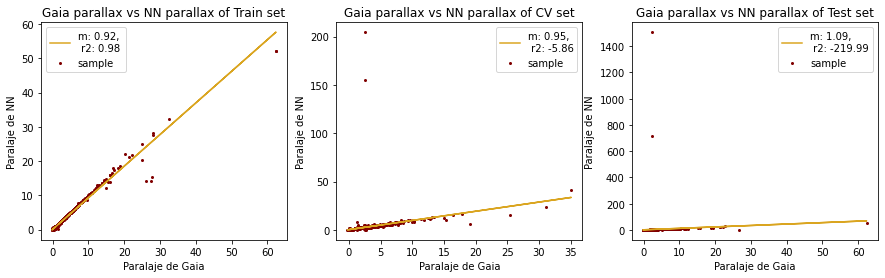

tamaño set entrenaiento:  6000 
 tamaño cv set:  2000 
 tamaño set de testeo:  2000


In [42]:
#visualization(Y_train , preds_train , Y_cv , preds_cv,Y_test,preds_test)

#visualization(Y_train_snr , preds_train_snr , Y_cv_snr , preds_cv_snr , Y_test_snr , preds_test_snr)

visualization(YY , pp_TRAIN, YY_TEST , pp_TEST , YY_CV , pp_CV )

In [29]:
#error_train = np.abs(Y_train-preds_train) / Y_train *100
#error_cv = np.abs(Y_cv-preds_cv) / Y_cv *100

#error_train_snr = np.abs( Y_train_snr - preds_train_snr ) / (np.abs(Y_train_snr)) *100
#error_cv_snr = np.abs(Y_cv_snr - preds_cv_snr) / (np.abs(Y_cv_snr)) *100
#error_test_snr = np.abs(Y_test_snr - preds_test_snr) / (np.abs(Y_test_snr)) *100

ERROR_train = np.abs( YY - pp_TRAIN ) / (np.abs(YY)) *100
ERROR_cv = np.abs(YY_CV - pp_CV) / (np.abs(YY_CV)) *100
ERROR_test = np.abs(YY_TEST - pp_TEST) / (np.abs(YY_TEST)) *100

In [30]:
#mean_error_train = sum(np.abs(error_train))/len(error_train)
#mean_error_cv = sum(np.abs(error_cv))/len(error_cv)
#mean_error_train , mean_error_cv

#mean_error_train_snr = sum(np.abs(error_train_snr))/len(error_train_snr)
#mean_error_cv_snr = sum(np.abs(error_cv_snr))/len(error_cv_snr)
#mean_error_test_snr = sum(np.abs(error_test_snr))/len(error_test_snr)
#mean_error_train_snr , mean_error_cv_snr, mean_error_test_snr

MEAN_error_train = sum(np.abs(ERROR_train))/len(ERROR_train)
MEAN_error_cv = sum(np.abs(ERROR_cv))/len(ERROR_cv)
MEAN_error_test = sum(np.abs(ERROR_test))/len(ERROR_test)
MEAN_error_train , MEAN_error_cv, MEAN_error_test

(array([43.65851356]), array([125.60883986]), array([85.67442929]))

In [32]:
#J_train, mse_train = Global_model.evaluate([X_train,Mag_train,X_offset_train], Y_train)
#print('MSE train: %.2f' % (mse_train))

#J_train, mse_train = Global_model.evaluate([X_train_snr,Mag_train_snr,X_offset_train_snr], Y_train_snr)
#print('MSE train: %.2f' % (mse_train))

J_train, mse_train = Global_model.evaluate([XX,MAGG,OFF], YY)
print('MSE train: %.2f' % (mse_train))

188/188 [==============================] - 1s 6ms/step - loss: 0.1284 - mse: 0.1284
MSE train: 0.13


In [33]:
#J_cv, mse_cv = Global_model.evaluate([X_cv,Mag_cv,X_offset_cv], Y_cv)
#print('MSE test: %.2f' % (mse_cv))

#J_cv, mse_cv = Global_model.evaluate([X_cv_snr,Mag_cv_snr,X_offset_cv_snr], Y_cv_snr)
#print('MSE cv: %.2f' % (mse_cv))

J_cv, mse_cv = Global_model.evaluate([XX_CV,MAGG_CV,OFF_CV], YY_CV)
print('MSE cv: %.2f' % (mse_cv))

63/63 [==============================] - 0s 6ms/step - loss: 1384.8292 - mse: 1384.8292
MSE cv: 1384.83


In [34]:
#J_test, mse_test = Global_model.evaluate([X_test,Mag_test,X_offset_test], Y_test)
#print('MSE test: %.2f' % (mse_cv))

#J_test, mse_test = Global_model.evaluate([X_test_snr,Mag_test_snr,X_offset_test_snr], Y_test_snr)
#print('MSE test: %.2f' % (mse_test))

J_test, mse_test = Global_model.evaluate([XX_TEST,MAGG_TEST,OFF_TEST], YY_TEST)
print('MSE test: %.2f' % (mse_test))

63/63 [==============================] - 0s 6ms/step - loss: 32.4127 - mse: 32.4127
MSE test: 32.41


OJO CAMBIARÉ EL CV SET POR EL TEST SET